# AWS Metrics Retriever
__Author : Paul Williams__</br>
__Version: 1.0__</br>
In the AWS Console you may only retrieve Metrics from the last 3 hours. The period for which metrics are held can be upto 15 months. To retrieve those metrics. Us this notebook.

In [1]:
import os
import boto3
import json
import pandas as pd
from time import time
from datetime import datetime, timedelta

In [2]:
MAX_DATAPOINTS   = 1440 # NOTE: this value is defined by Amazon 
SHOW_DETAILS     = True

Set the name of your AWS profile. This defines the account that you wish to retrieve metrics from. This can be different to the account that you logged into.</br>__Note:__ prior to executing this notebook, you must have logged into AWS. You must have done this within the same environment as the notebook is running. If you are not sure, open a JupyterLabs __Terminal__ window and login to AWS there.

In [3]:
AWS_PROFILE_NAME = '<REPLACE WITH YOUR AWS PROFILE NAME>'

Enter the dimensions used to retrieve the metrics. In the default case here there are 3 dimentions. But, in your case, you may have fewer, or more.

In [4]:
DIMENSIONS = [{'Name' : 'ClusterName',
               'Value': '<REPLACE WITH YOUR CLUSTER NAME>'},
              {'Name' : 'InstanceId',
               'Value': '<REPLACE WITH YOUR INSTANCE ID'},
              {'Name' : 'NodeName',
               'Value': 'REPLACE WITH YOUR NODE NAME'}]

Import configuration overrides from local file configuration.py. If it exists, this will import values from an external configuration file that will override those set previously in this notebook.
Note: the Kernel must be restarted after changes to the configuration.py. Otherwise the changes will not be imported into the notebook.

In [5]:
# Import overrides 
if os.path.isfile('./configuration.py'): 
    import configuration as cfg
    # Configure the overrides
    SHOW_DETAILS     = cfg.SHOW_DETAILS
    AWS_PROFILE_NAME = cfg.AWS_PROFILE_NAME
    DIMENSIONS       = cfg.DIMENSIONS

In [6]:
session = boto3.Session(profile_name = AWS_PROFILE_NAME)
client  = session.client('cloudwatch')

## Metric Retrieval Functions
This section contains the functions used to retriev the data.

In [7]:
class AWSQueryTimeIntervalPeriodTooSmall(Exception): pass
class AWSQueryTimeIntervalPeriodInvalidValue(Exception): pass

def validatePeriodLength(Period:int = 0):
    # Compare the Period value against the validation rules. 
    # Raise an error if it is not valid
    if Period    < 60: raise AWSQueryTimeIntervalPeriodTooSmall('The minimum size of the time period is 60.')
    if Period%60 != 0: raise AWSQueryTimeIntervalPeriodInvalidValue('The time period must be a multiple of 60.')

In [8]:
def getDateTimePair(StartTime:datetime, 
                    EndTime:datetime, 
                    Period:int):
    
    # Calculate the difference in time between the start and the end
    deltaTime      = EndTime - StartTime
    # Calculate the number of datapoints within the deltatime
    datapointCount = deltaTime.total_seconds() / Period
    # The Dict to hold the StartTime and EndTime values
    timeListDict   = {}
    # Before we begin. Set the initial StartTime
    timeListDict['StartTime'] = StartTime
    # Set the EndTime to either the actual EndTime or to the StartTime 
    # plus the max number of datapoint periods        
    timeListDict['EndTime'] = EndTime if datapointCount <= MAX_DATAPOINTS else StartTime + timedelta(seconds = MAX_DATAPOINTS * Period)
        
    return timeListDict

In [9]:
def generateDateTimeList(StartTime:datetime, 
                         EndTime:datetime, 
                         Period:int):
    
    timeListDict = {}
    iteration    = 0
    # Construct a Dict of Start/End times each encapsulating the max datapoints, 
    # or as many datapoints to the upto the EndTime
    while StartTime < EndTime:
        # Generate a datetime pair 
        timeListDict[iteration] = getDateTimePair(StartTime, EndTime, Period)
        # Reset the StartTime
        StartTime = EndTime if timeListDict[iteration]['EndTime'] is None else timeListDict[iteration]['EndTime']
        # I do not have to explain this
        iteration += 1
        
    return timeListDict

In [10]:
def requestData(StartTime:datetime, 
                EndTime:datetime, 
                Period:int):
    
    # Make the call to the AWS API
    response = client.get_metric_statistics(
        Namespace  = 'ContainerInsights',
        MetricName = 'node_memory_utilization',
        Dimensions = DIMENSIONS,
        StartTime  = StartTime,
        EndTime    = EndTime,
        Period     = Period,
        Statistics = ['Average']
    )  
    
    return pd.DataFrame(response['Datapoints'])

In [11]:
def retrieveMetrics(StartTime:datetime = datetime.now() - timedelta(hours=0), 
                    EndTime:datetime   = datetime.now(), 
                    Period:int         = 300):
    
    validatePeriodLength(Period)
    
    dataList_df = pd.DataFrame()
    
    # Create a list of start/end time pairs that contain the maximum number 
    # of datapoints. So that the metrics for the entire period can be retrieved 
    # with the minimum amount of calls to the AWS API
    requestTimesList = generateDateTimeList(StartTime = StartTime, 
                                            EndTime   = EndTime, 
                                            Period    = Period)
    
    # Loop through all of the time periods defined by start/end time pairs and
    # append the data to the dataList_df dataframe
    for idx in requestTimesList:
        # Rest metrics from the API
        data_df = requestData(StartTime = requestTimesList[idx]['StartTime'], 
                              EndTime   = requestTimesList[idx]['EndTime'], 
                              Period    = Period)
        # Append the metrics data to the dataList_df dataframe. Removing any
        # duplicates that may have been created
        dataList_df = pd.concat([dataList_df, data_df]).drop_duplicates().reset_index(drop=True) if dataList_df.size > 0 else data_df
    
    # Remove TimeZone from column Timestamp if it is present
    if 'Timestamp' in dataList_df.columns:   
        dataList_df['Timestamp'] = dataList_df['Timestamp'].dt.tz_localize(None)
        
    # Set the Timestamp ans the index and sort by the index. 
    # So that the returned dataframe is in chronological order   
    dataList_df = dataList_df.set_index('Timestamp').sort_index() if 'Timestamp' in dataList_df.columns else dataList_df
            
    return dataList_df

## Examples
__Note:__ before running these examples. Ensure that all fields above have been successfully executed.

### 1] Retrieve a dataframe of metrics

In [12]:
# Set the time range and period length
StartTime = datetime(2023, 11, 16)
EndTime   = datetime(2023, 11, 17)
Period    = 60
# Retieve the metrics and display the first 5 records
retrieveMetrics(StartTime, EndTime, Period).head(5)

,Average,Unit
Timestamp,,
2023-11-16 00:00:00,35.582774,Percent
2023-11-16 00:01:00,35.688429,Percent
2023-11-16 00:02:00,35.876278,Percent
2023-11-16 00:03:00,35.560730,Percent
2023-11-16 00:04:00,36.045308,Percent


### 2] Retrieve metrics and write them to a CSV file

In [13]:
# Set the time range and period length
StartTime    = datetime(2023, 11, 16)
EndTime      = datetime(2023, 11, 17)
Period       = 60
# Retieve the metrics and display the first 5 records
metrics_df   = retrieveMetrics(StartTime, EndTime, Period)
# Location of our data files
DATA_PATH    = './data/'
# Generate a string from the dimension values
dimensionStr = "_".join([dimension['Value'] for dimension in DIMENSIONS])
# Write a csv file with a unique filename
metrics_df.to_csv("".join([DATA_PATH, 'aws-metrics_', str(int(time())), '_', dimensionStr,'.csv']))

### 3] Retrieve metrics and write them to an MS Excel file
__Note:__ this example requires the Python package <code>openpyxl</code> to have been previously installed.

In [14]:
# Set the time range and period length
StartTime    = datetime(2023, 11, 16)
EndTime      = datetime(2023, 11, 17)
Period       = 60
# Retieve the metrics and display the first 5 records
metrics_df   = retrieveMetrics(StartTime, EndTime, Period)
# Location of our data files
DATA_PATH    = './data/'
# Generate a string from the dimension values
dimensionStr = "_".join([dimension['Value'] for dimension in DIMENSIONS])
# Write an MS Excel file with a unique filename
metrics_df.to_excel("".join([DATA_PATH, 'aws-metrics_', str(int(time())), '_', dimensionStr,'.xlsx']))

### 4] Retrieve metrics and plot a line chart
__Note:__ this example requires the Python package <code>matplotlib</code> to have been previously installed.

In [15]:
# Set the time range and period length
StartTime = datetime(2023, 10, 14)
EndTime   = datetime(2023, 11, 17)
Period    = 300
# Retieve the metrics and display the first 5 records
metrics_df = retrieveMetrics(StartTime, EndTime, Period)

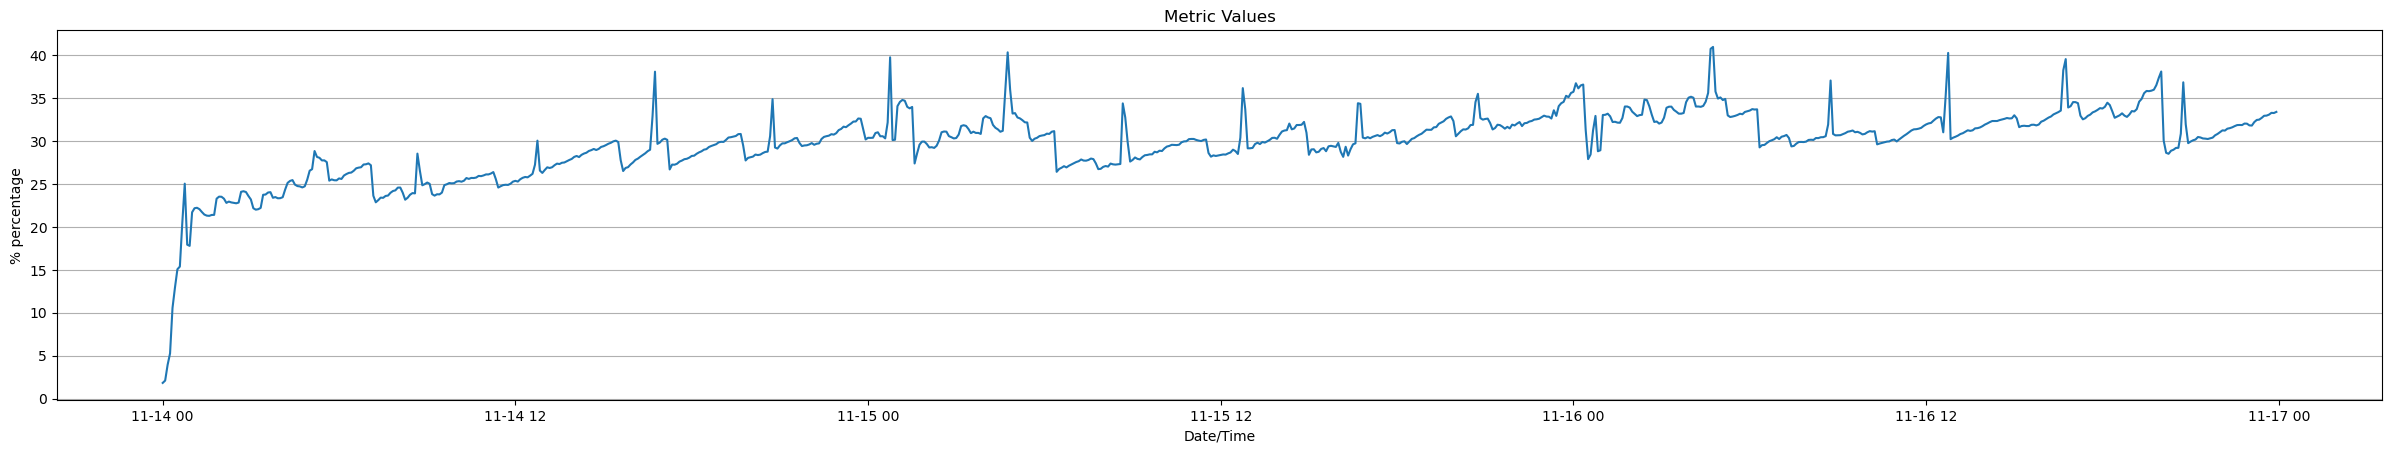

In [16]:
import matplotlib.pyplot as plt

# Define the data
x = metrics_df.index
y = metrics_df['Average'] 
# Set the width of the plot
plt.figure().set_figwidth(30)
# Set plot attributes
plt.plot(x,y)
plt.grid(axis = 'y')
plt.xlabel('Date/Time')
plt.ylabel('% percentage')
plt.title("".join(["Metric Values for Dimensions: ", ", ".join([dimension['Value'] for dimension in DIMENSIONS])])) if SHOW_DETAILS else plt.title("Metric Values") 
# Display the plot
plt.show()